# 1. Library 

In [1]:
## Parameters specific to where your folders are and your data
parameter_file = 'params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
anno_gff=doc['annotation']
mRNA_peak_file = doc["mRNA_peak_file"]

tss_annotation = doc['tss_annotation']


import os
os.chdir
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm

from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from Homer import *
import plot_tss_results
print('Number of tissues: ',len(tissues))

('Number of tissues: ', 13)


In [2]:
if not os.path.exists("Results/Figures/SuppFigure_TisSpec"):
    os.mkdir("Results/Figures/SuppFigure_TisSpec")

# 2. Load and Preprocessing

## Read in expression matrix

In [3]:
tissues_expr = pd.read_csv("Results/merged/tissues.merge.peaksexpression.log10",sep="\t",index_col=0)
tissues_expr.head()

,Heart,Spleen,MiscOrgans,FemaleReproductive,CHO,BMDM1hKLA,Brain,Lung,Liver,BMDMwt,Muscle,Kidney,Pancreas
0,0.213256,0.000000,0.191009,0.177054,1.379905,1.93044,0.192445,0.292457,0.000000,0.000000,0.192803,0.289548,0.000000
1,0.000000,0.569562,0.658306,0.704879,0.000000,0.00000,0.365353,0.875756,0.211156,0.000000,0.160073,0.206016,0.000000
2,0.000000,0.272654,0.191009,0.650337,1.269450,0.00000,0.285237,0.440272,0.000000,0.823474,0.252575,0.377071,0.299942
3,0.213256,0.583265,0.592983,0.556972,0.347363,0.00000,0.633209,0.256951,0.000000,0.537819,0.300486,0.216445,0.380588
4,0.858835,1.743575,1.998797,1.218955,0.698374,0.00000,1.707621,0.729080,0.945703,0.642465,1.198361,0.838893,1.141651


### Read in promoter output

In [4]:
tss_meta = pd.read_csv("Results/output/TSS1.exp.meta",sep="\t",index_col=0)
tss_meta["Name"] = tss_meta.index
tss_meta.set_index("ID",inplace=True)
tss_meta.head()

,Tissues,cs,CHO ATAC Region,Gene,Gene ID,Transcript,Is Experimental,Name
ID,,,,,,,,
348823,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b11,NaN,Bmp4,NaN,XM_027386529.1,1.0,p1@Bmp4_XM_027386529.1
90264,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b00,NaN,Bmp4,NaN,XM_027386529.1,1.0,p2@Bmp4_XM_027386529.1
181215,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b00,NaN,Bmp4,NaN,XM_027386529.1,1.0,p3@Bmp4_XM_027386529.1
308710,"Heart,Spleen,MiscOrgans,FemaleReproductive,Bra...",0b11,NaN,Bmp4,NaN,XM_027386528.1,1.0,p1@Bmp4_XM_027386528.1
237253,"BMDMwt,Spleen,MiscOrgans,FemaleReproductive,CH...",0b11,NaN,Cdkn3,NaN,XM_027386531.1,1.0,p1@Cdkn3_XM_027386531.1


## Extract promoter peaks

In [5]:
prom_tissue = tissues_expr.loc[tissues_expr.index.isin(tss_meta.index)]
prom_tissue.head()

,Heart,Spleen,MiscOrgans,FemaleReproductive,CHO,BMDM1hKLA,Brain,Lung,Liver,BMDMwt,Muscle,Kidney,Pancreas
4,0.858835,1.743575,1.998797,1.218955,0.698374,0.000000,1.707621,0.729080,0.945703,0.642465,1.198361,0.838893,1.141651
5,0.401729,1.308001,1.395354,0.648333,0.000000,0.000000,0.934077,0.962747,0.864244,0.328380,1.110788,0.902202,1.001847
6,0.815153,0.519195,1.187007,0.253253,0.418561,0.000000,0.285242,0.256951,1.480135,0.561101,0.964390,0.899657,0.826164
8,0.700905,0.681902,0.877857,0.600699,0.213637,0.849419,0.858705,0.749040,0.442105,1.089905,0.633441,0.483976,0.623310
12,0.000000,0.128118,0.000000,0.000000,0.000000,0.000000,0.000000,0.241971,0.774026,0.000000,0.151598,0.000000,0.000000


## Create median and max values


In [6]:
tss_meta["Median"] = prom_tissue.median(axis=1)
tss_meta["Max"] = prom_tissue.max(axis=1)
tss_meta.head()

,Tissues,cs,CHO ATAC Region,Gene,Gene ID,Transcript,Is Experimental,Name,Median,Max
ID,,,,,,,,,,
348823,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b11,NaN,Bmp4,NaN,XM_027386529.1,1.0,p1@Bmp4_XM_027386529.1,0.260824,0.949261
90264,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b00,NaN,Bmp4,NaN,XM_027386529.1,1.0,p2@Bmp4_XM_027386529.1,0.000000,0.253253
181215,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b00,NaN,Bmp4,NaN,XM_027386529.1,1.0,p3@Bmp4_XM_027386529.1,0.000000,0.193642
308710,"Heart,Spleen,MiscOrgans,FemaleReproductive,Bra...",0b11,NaN,Bmp4,NaN,XM_027386528.1,1.0,p1@Bmp4_XM_027386528.1,1.045548,2.262918
237253,"BMDMwt,Spleen,MiscOrgans,FemaleReproductive,CH...",0b11,NaN,Cdkn3,NaN,XM_027386531.1,1.0,p1@Cdkn3_XM_027386531.1,0.207487,0.658520


### Removing 0s when calculating the median

In [7]:
tss_meta["Median no 0"] = prom_tissue.apply(lambda x: x[x>0].median(),axis=1)
tss_meta["Only 1"] = (prom_tissue>0).sum(axis=1) <= 1

### Create a gene-of-interest list inspired by 
#### A promoter-level mammalian expression atlas Figure 2

In [8]:
goi = ["ALB","GFAP","H19","IRF9","TP53"]

In [9]:
tss_meta[~tss_meta["Only 1"]][tss_meta[~tss_meta["Only 1"]]["Gene"].isin(goi)]

,Tissues,cs,CHO ATAC Region,Gene,Gene ID,Transcript,Is Experimental,Name,Median,Max,Median no 0,Only 1
ID,,,,,,,,,,,,


# 3. Plotting

## Plot the two

### Without removing 0s

(0, 2)

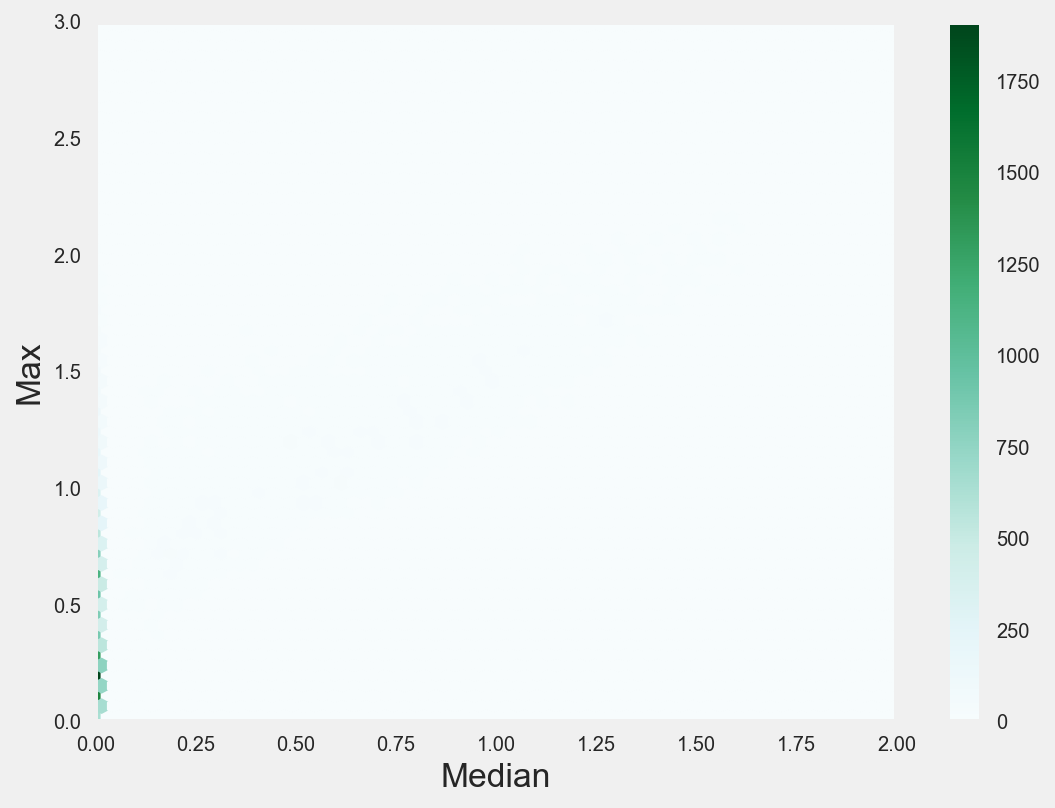

In [10]:
tss_meta.plot.hexbin(x="Median",y="Max")

for ind,val in tss_meta[tss_meta["Gene"].isin(["ALB","GFAP","H19","IRF9","TP53"])].iterrows():
    val["Median"]
    plt.gca().text(val["Median"],val["Max"],val["Gene"])

plt.ylim([0,3])
plt.xlim([0,2])

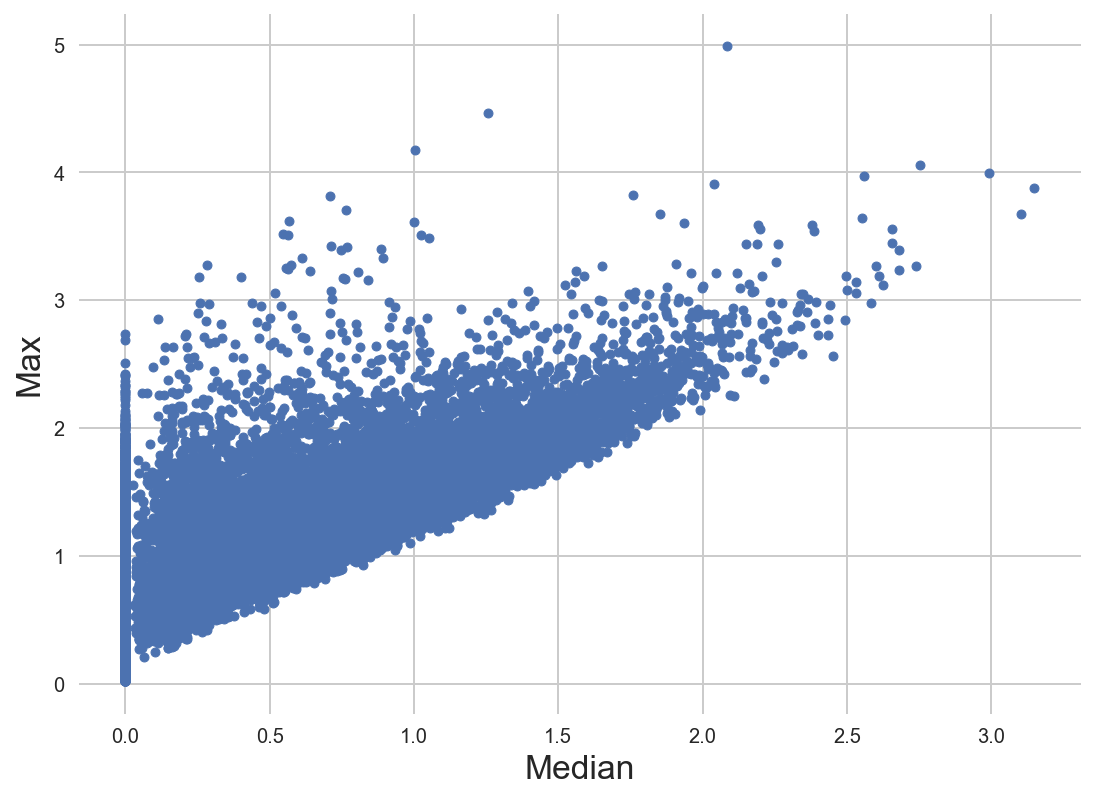

In [11]:
tss_meta.plot.scatter(x="Median",y="Max")

for ind,val in tss_meta[tss_meta["Gene"].isin(["ALB","GFAP","H19","IRF9","TP53"])].iterrows():
    val["Median"]
    plt.gca().text(val["Median"],val["Max"],val["Name"].split("_")[0])

# plt.ylim([0,3])
# plt.xlim([0,2])
plot_tss_results.helper_save("Results/Figures/SuppFigure_TisSpec/TisSpec_all.png")

## Median on values that had a peak (so no 0s included)

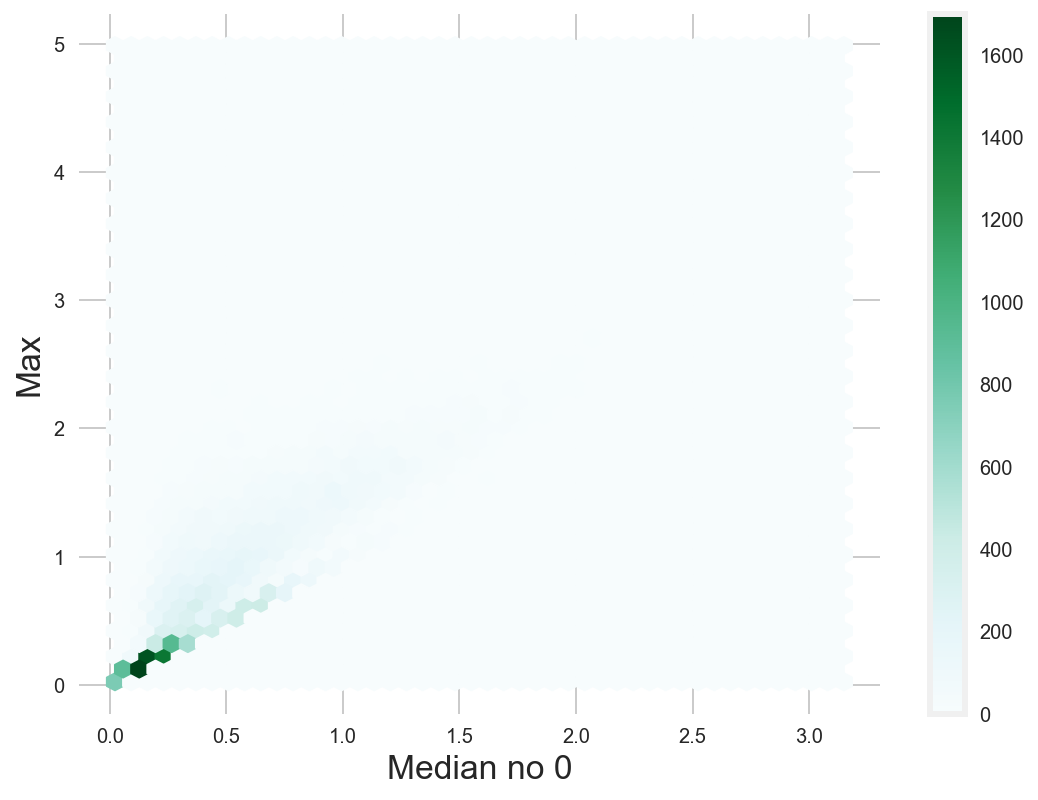

In [12]:
tss_meta.plot.hexbin(x="Median no 0",y="Max",gridsize=45)
# plt.xlim([0,1])
# plt.ylim([0,1])
for ind,val in tss_meta[tss_meta["Gene"].isin(goi)].iterrows():
    val["Median no 0"]
    plt.gca().text(val["Median no 0"],val["Max"],val["Name"].split("_")[0])
    
plot_tss_results.helper_save("Results/Figures/SuppFigure_TisSpec/TisSpec_no0.png")

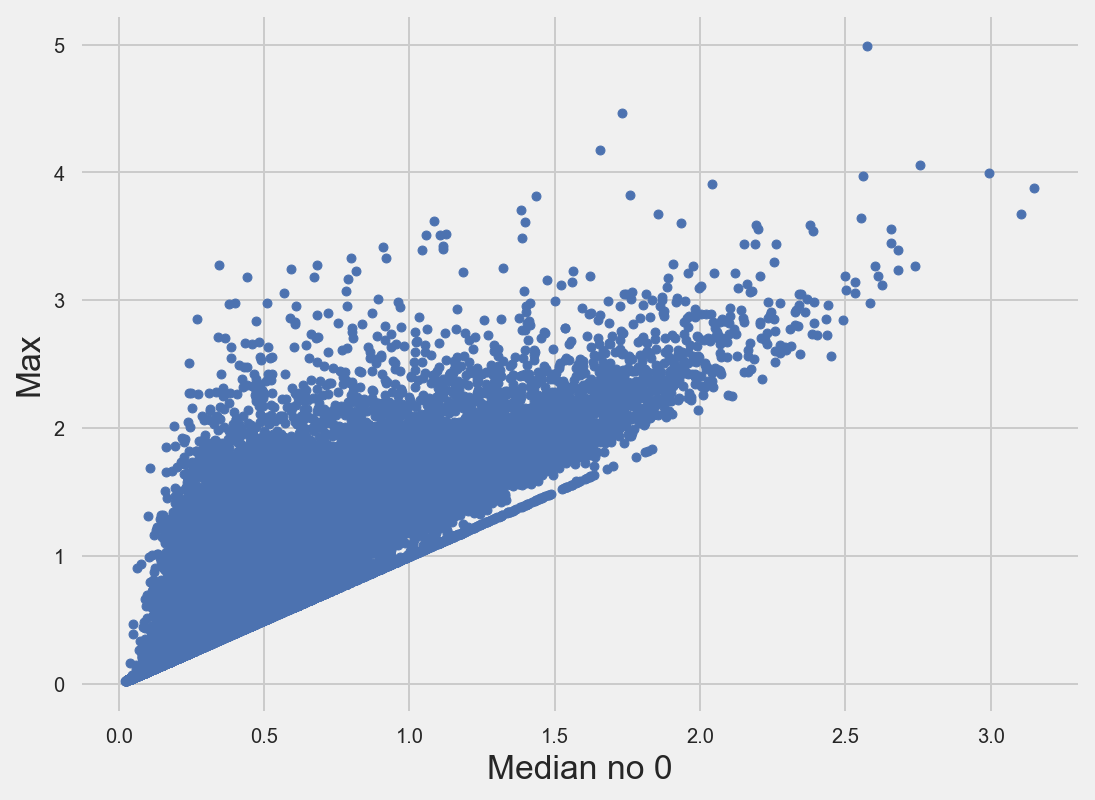

In [13]:
tss_meta.plot.scatter(x="Median no 0",y="Max")
for ind,val in tss_meta[tss_meta["Gene"].isin(goi)].iterrows():
    val["Median no 0"]
    plt.gca().text(val["Median no 0"],val["Max"],val["Name"].split("_")[0])

# plt.xlim([0,1])
# plt.ylim([0,1])

## Removing points that were only in one tissue

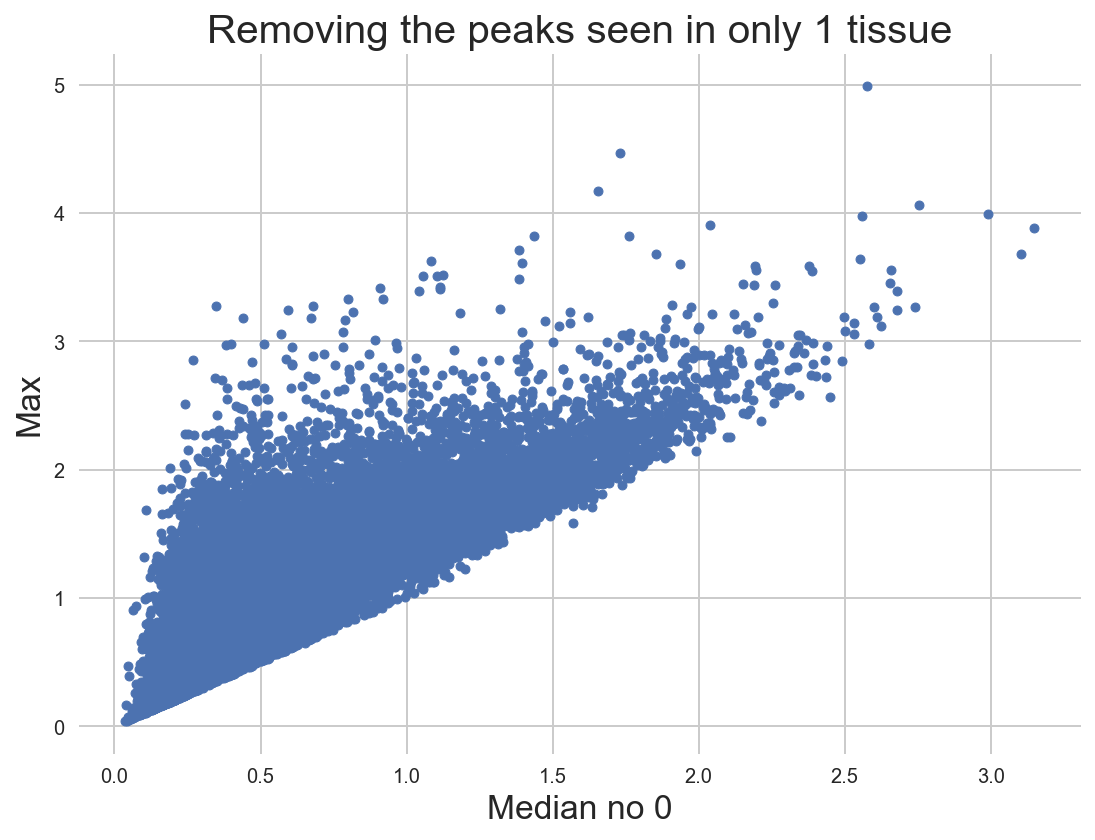

In [14]:
tss_meta[~tss_meta["Only 1"]].plot.scatter(x="Median no 0", y="Max")
plt.title("Removing the peaks seen in only 1 tissue")

for ind, val in tss_meta[~tss_meta["Only 1"]][tss_meta[~tss_meta["Only 1"]][
        "Gene"].isin(goi)].iterrows():
    val["Median"]
    plt.gca().text(val["Median"], val["Max"], val["Name"].split("_")[0])
    

plot_tss_results.helper_save("Results/Figures/SuppFigure_TisSpec/TisSpec_no1tis.png")

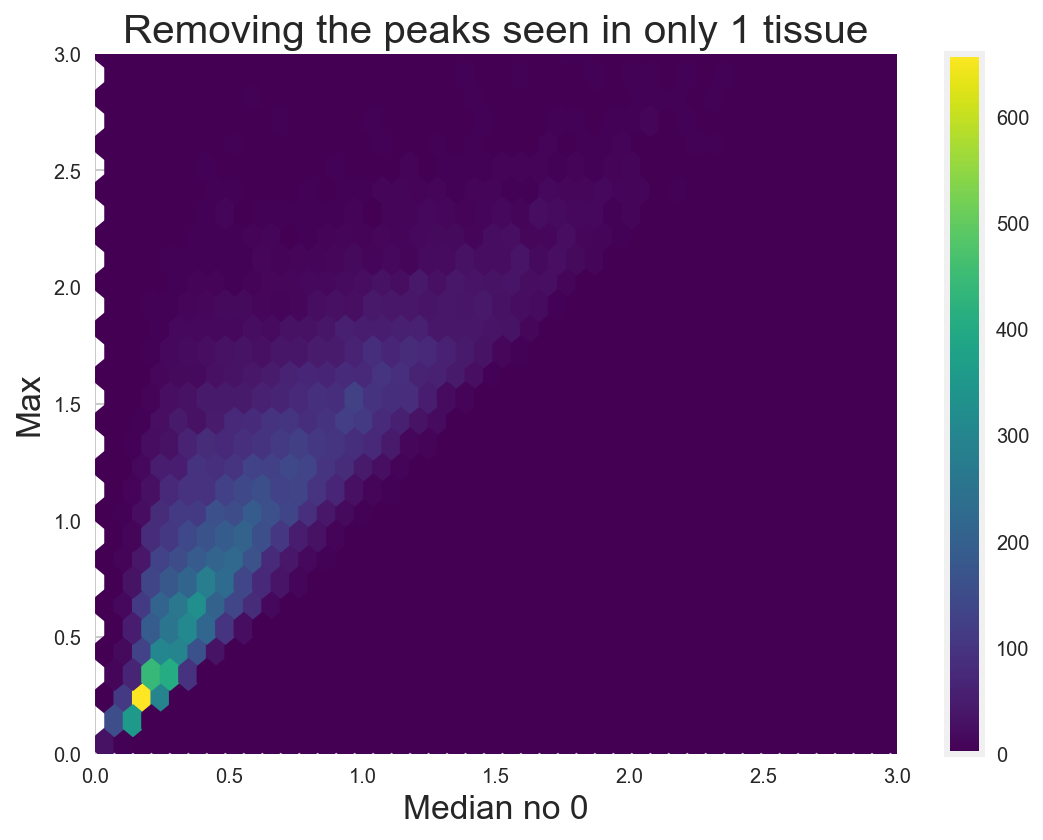

In [15]:
tss_meta[~tss_meta["Only 1"]].plot.hexbin(
    x="Median no 0", y="Max", gridsize=45, cmap=plt.cm.viridis)
plt.title("Removing the peaks seen in only 1 tissue")
plt.xlim([0, 3])
plt.ylim([0, 3])
plot_tss_results.helper_save("Results/Figures/SuppFigure_TisSpec/TisSpec_no1tis_hex.png")

(0, 3)

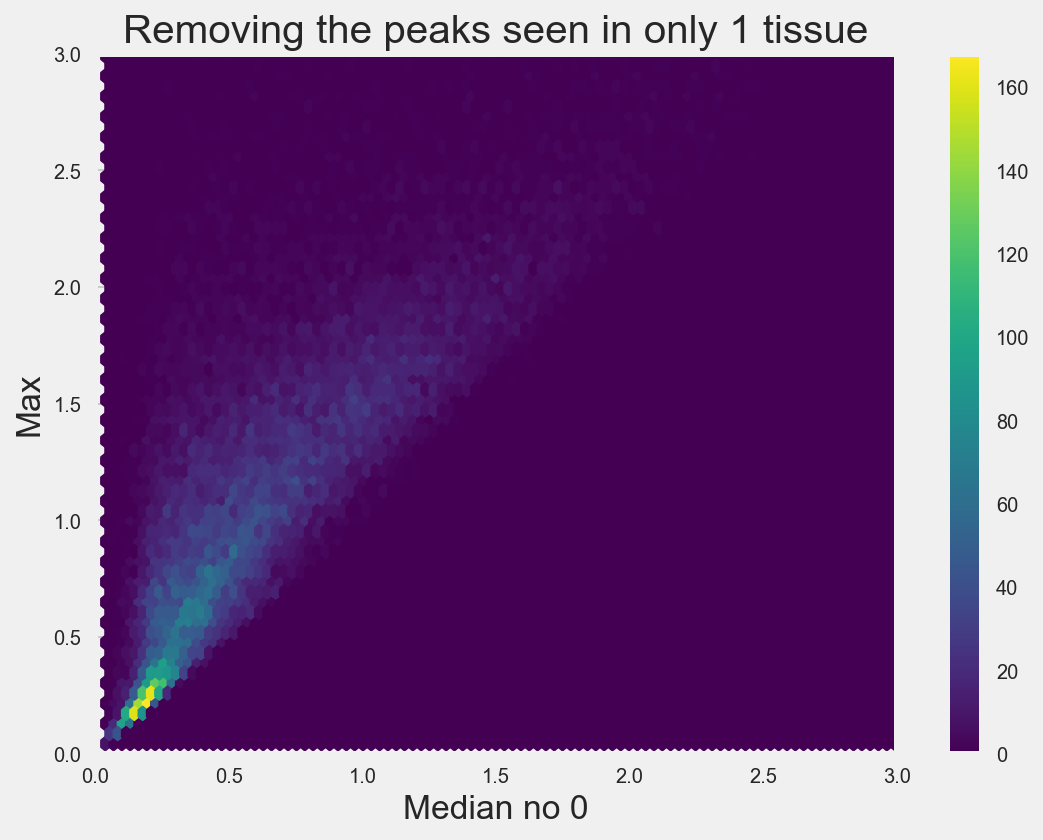

In [16]:
tss_meta[~tss_meta["Only 1"]].plot.hexbin(
    x="Median no 0", y="Max", gridsize=100, cmap=plt.cm.viridis)
plt.title("Removing the peaks seen in only 1 tissue")
plt.xlim([0, 3])
plt.ylim([0, 3])